Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set_theme(style="whitegrid", palette="colorblind")

Loading data

In [2]:
df = pd.read_csv(
    "D:/kifiya AI/Insurance-Risk-Analytics-and-predictive-modeling/data/MachineLearningRating_v3.txt",
    sep="|",
    engine="python"
)
print("Shape:", df.shape)

Shape: (1000099, 52)


checking

In [3]:
df[["Province","PostalCode","Gender","TotalPremium","TotalClaims"]].head()


,Province,PostalCode,Gender,TotalPremium,TotalClaims
0,Gauteng,1459.0,Not specified,21.929825,0.0
1,Gauteng,1459.0,Not specified,21.929825,0.0
2,Gauteng,1459.0,Not specified,0.000000,0.0
3,Gauteng,1459.0,Not specified,512.848070,0.0
4,Gauteng,1459.0,Not specified,0.000000,0.0


KPI definitions

In [4]:
df["HasClaim"] = (df["TotalClaims"] > 0).astype(int)
df["ClaimFrequency"] = df["HasClaim"]          
df["ClaimSeverity"]  = df["TotalClaims"].where(df["HasClaim"]==1)
df["Margin"] = df["TotalPremium"] - df["TotalClaims"]

KPI summary

In [5]:
kpi_summary = df.agg(
    ClaimFrequency=("HasClaim","mean"),
    AvgSeverity=("ClaimSeverity","mean"),
    AvgMargin=("Margin","mean")
).round(4)
kpi_summary

,HasClaim,ClaimSeverity,Margin
ClaimFrequency,0.0028,NaN,NaN
AvgSeverity,NaN,23273.3871,NaN
AvgMargin,NaN,NaN,-2.9557


Balanced splitter

In [6]:
from sklearn.model_selection import train_test_split
def balanced_split(df, feature, group_a, group_b, seed=42):
    
    mask = df[feature].isin([group_a, group_b])
    
    sub = df[mask].copy()
    sub["strat"] = (sub["VehicleType"].astype(str) + "_" +
                    sub["CoverType"].astype(str) + "_" +
                    pd.cut(sub["CustomValueEstimate"], 3, labels=False).astype(str))
    a_idx = sub[sub[feature]==group_a].index
    b_idx = sub[sub[feature]==group_b].index

    min_size = min(len(a_idx), len(b_idx))
    a_idx = a_idx.to_series().sample(min_size, random_state=seed)
    b_idx = b_idx.to_series().sample(min_size, random_state=seed)
    return sub.loc[a_idx], sub.loc[b_idx]

Province counts

In [7]:
prov_counts = df["Province"].value_counts()
prov_counts.head()


Province
Gauteng          393865
Western Cape     170796
KwaZulu-Natal    169781
North West       143287
Mpumalanga        52718
Name: count, dtype: int64

Balanced groups

In [8]:
gauteng, wcape = balanced_split(df, "Province", "Gauteng", "Western Cape")

χ² test for Claim Frequency

In [9]:
contingency = pd.crosstab(
    np.hstack([gauteng["HasClaim"], wcape["HasClaim"]]),
    np.hstack([np.repeat("Gauteng", len(gauteng)),
               np.repeat("WCape", len(wcape))])
)
chi2, p_freq, dof, exp = chi2_contingency(contingency)
print(f"χ² = {chi2:.3f},  p = {p_freq:.4f}")

χ² = 43.775,  p = 0.0000


Mann-Whitney U for Severity

In [10]:
_, p_sev = mannwhitneyu(gauteng["ClaimSeverity"].dropna(),
                        wcape["ClaimSeverity"].dropna(),
                        alternative='two-sided')
print(f"Mann-Whitney p = {p_sev:.4f}")

Mann-Whitney p = 0.4162


Interpret

In [11]:
def interpret(p, metric, group_a, group_b, alpha=0.05):
    if p < alpha:
        return f"Reject H₀ (p={p:.3f}). Significant difference in {metric} between {group_a} and {group_b}."
    else:
        return f"Fail to reject H₀ (p={p:.3f}). No significant difference in {metric}."

print(interpret(p_freq, "ClaimFrequency", "Gauteng", "WCape"))
print(interpret(p_sev, "ClaimSeverity", "Gauteng", "WCape"))

Reject H₀ (p=0.000). Significant difference in ClaimFrequency between Gauteng and WCape.
Fail to reject H₀ (p=0.416). No significant difference in ClaimSeverity.


Zip counts

In [13]:
zip_counts = df["PostalCode"].value_counts().head(2)
zip_a, zip_b = zip_counts.index
zip_a, zip_b

(2000.0, 122.0)

Balanced zip groups

In [15]:
zipA, zipB = balanced_split(df, "PostalCode", zip_a, zip_b)

χ² for frequency

In [16]:
contingency_z = pd.crosstab(
    np.hstack([zipA["HasClaim"], zipB["HasClaim"]]),
    np.hstack([np.repeat("ZipA", len(zipA)),
               np.repeat("ZipB", len(zipB))])
)
chi2_z, p_freq_z, _, _ = chi2_contingency(contingency_z)
print(f"Zip χ² = {chi2_z:.3f},  p = {p_freq_z:.4f}")

Zip χ² = 1.593,  p = 0.2069


Mann-Whitney for severity

In [17]:
_, p_sev_z = mannwhitneyu(zipA["ClaimSeverity"].dropna(),
                          zipB["ClaimSeverity"].dropna())
print(f"Zip Mann-Whitney p = {p_sev_z:.4f}")

Zip Mann-Whitney p = 0.0021


Clip extreme outliers for normality

In [18]:
marginA = zipA["Margin"].clip(lower=zipA["Margin"].quantile(0.01),
                              upper=zipA["Margin"].quantile(0.99))
marginB = zipB["Margin"].clip(lower=zipB["Margin"].quantile(0.01),
                              upper=zipB["Margin"].quantile(0.99))

t-test

In [19]:
t_stat, p_margin = ttest_ind(marginA, marginB, equal_var=False)
print(f"Zip Margin t-test p = {p_margin:.4f}")

Zip Margin t-test p = 0.0000


Gender counts

In [20]:
df["Gender"].value_counts()


Gender
Not specified    940990
Male              42817
Female             6755
Name: count, dtype: int64

Balanced gender split

In [21]:
male, female = balanced_split(df, "Gender", "Male", "Female")

χ² frequency

In [22]:
contingency_g = pd.crosstab(
    np.hstack([male["HasClaim"], female["HasClaim"]]),
    np.hstack([np.repeat("Male", len(male)),
               np.repeat("Female", len(female))])
)
chi2_g, p_freq_g, _, _ = chi2_contingency(contingency_g)
print(f"Gender χ² = {chi2_g:.3f},  p = {p_freq_g:.4f}")

Gender χ² = 0.160,  p = 0.6889


Mann-Whitney severity

In [23]:
_, p_sev_g = mannwhitneyu(male["ClaimSeverity"].dropna(),
                          female["ClaimSeverity"].dropna())
print(f"Gender Mann-Whitney p = {p_sev_g:.4f}")

Gender Mann-Whitney p = 0.4269


Summary dataframe

In [24]:
results = pd.DataFrame({
    "Hypothesis": [
        "Risk diff provinces (freq)",
        "Risk diff provinces (sev)",
        "Risk diff zip codes (freq)",
        "Risk diff zip codes (sev)",
        "Margin diff zip codes",
        "Risk diff gender (freq)",
        "Risk diff gender (sev)"
    ],
    "p_value": [p_freq, p_sev, p_freq_z, p_sev_z, p_margin, p_freq_g, p_sev_g],
    "Significant (α=0.05)": lambda x: x < 0.05
})
results["Reject_H0"] = results["p_value"] < 0.05
results.style.background_gradient(subset=["p_value"], cmap="Reds")

,Hypothesis,p_value,Significant (α=0.05),Reject_H0
0,Risk diff provinces (freq),0.000000,at 0x0000026394AC1120>,True
1,Risk diff provinces (sev),0.416178,at 0x0000026394AC1120>,False
2,Risk diff zip codes (freq),0.206944,at 0x0000026394AC1120>,False
3,Risk diff zip codes (sev),0.002150,at 0x0000026394AC1120>,True
4,Margin diff zip codes,0.000000,at 0x0000026394AC1120>,True
5,Risk diff gender (freq),0.688884,at 0x0000026394AC1120>,False
6,Risk diff gender (sev),0.426866,at 0x0000026394AC1120>,False


Effect size plot

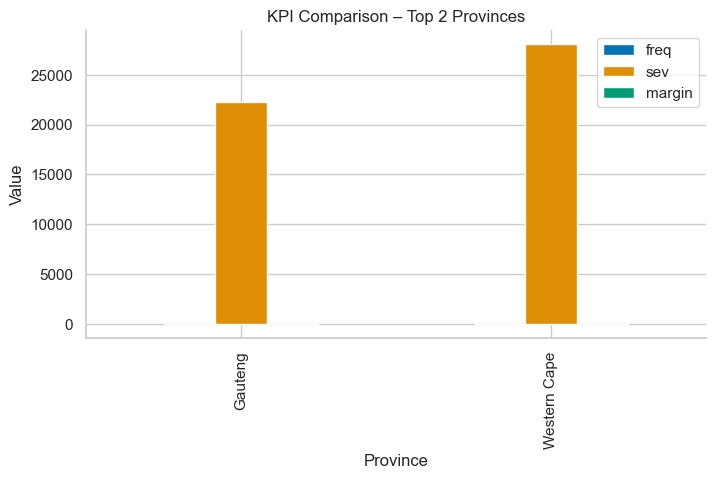

In [26]:
prov_stats = (df.groupby("Province")
                .agg(freq=("HasClaim","mean"),
                     sev=("ClaimSeverity","mean"),
                     margin=("Margin","mean"))
                .loc[["Gauteng","Western Cape"]])
prov_stats.plot(kind="bar", figsize=(8,4), title="KPI Comparison – Top 2 Provinces")
plt.ylabel("Value"); sns.despine()